In [1]:
import os
import json
from docx import Document
from io import StringIO, BytesIO
import re
import time
import datetime

import pandas as pd
import json
import spacy
from nltk.corpus import stopwords

from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim import matutils, models
from gensim.models import CoherenceModel, TfidfModel, HdpModel
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis.gensim

from docx import Document
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 3})

In [2]:
nlp = spacy.load("en_core_web_sm")
# stop_words = set(stopwords.words('english'))

In [3]:
notebook_dir = os.getcwd()
situ_df = pd.read_csv('../data/interim/calltaker_situation.csv', 
                      keep_default_na = False, 
                     converters = {'sop': eval})

In [4]:
# situ_df = situ_df[situ_df['situation'].str.len() > 0].reset_index(drop = True)
situ_df

,role,situation,sop,filename
0,call taker,CBSA alarm policy,"[Listen to alarm, Acknowledge the alarm by pre...",DE - 1033 - Officer in trouble.docx
1,call taker,All other DOMI reports,[Create a call in every instance. Do not cance...,AB - DOMI - Domestic in progress.docx
2,call taker,GPS Panic Alarms,"[Create a call, Remain on the line recording a...",AB - DOMI - Domestic in progress.docx
3,call taker,Address Obtained,"[Run address on QBA:, If the person is negativ...",AB - FOUNDP - Found Person.docx
4,call taker,Name or medic alert is known,"[Run name on CPIC, If the person is negative o...",AB - FOUNDP - Found Person.docx
...,...,...,...,...
3589,call taker,All Other DVERS personal residential alarms,"[Create a call, Check hazards which will show ...",AB - ALARMD - Domestic violence alarm.docx
3590,call taker,DVERS Alarm maintenance,[See “Assist GP” for a stand by keep the peac...,AB - ALARMD - Domestic violence alarm.docx
3591,call taker,GPS tracked Panic Alarms,[See AB-DOMI],AB - ALARMD - Domestic violence alarm.docx
3592,call taker,DNA Warrant:,[See WARRAN (Warrants) SOP],NW - DNA - DNA collection .docx


In [5]:
def preprocess(strlist,
               min_token_len = 2,
               allowed_pos = ['ADV', 'ADJ', 'VERB', 'NOUN', 'PART', 'NUM', 'PROPN']): 
    removal = ['-', r'i\.e\.']
    res = list()
    not_stopword = {'call'}
    for string in strlist:
        text = re.sub(r"|".join(removal), ' ', string.lower())
        doc = nlp(text)
        res += [token.lemma_ for token in doc \
               if token.pos_ in allowed_pos \
               # Spacy considers 'call' as a stop word, which is not suitable for our case
               and (token.text in not_stopword or not token.is_stop) \
#                and token.text not in stop_words \              
#                and token.is_alpha \
               and len(token.lemma_) > min_token_len
               ]
    
    return ' '.join(res)

In [8]:
def get_dct_dtmatrix(sops):
    corpus = [sop.split() for sop in map(preprocess, sops)]
#     phrases = Phrases(corpus, min_count = 1, threshold = 1)
#     bigram = Phraser(phrases)
#     corpus = bigram(corpus)
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    return doc_term_matrix, corpus, dictionary

In [9]:
doc_term_bow, corpus, dictionary = get_dct_dtmatrix(situ_df['sop'])

In [10]:
def topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                          passes = 20,
                          N = 400, random_state = 2020):
    num_topic, ldas, cv_scores, npmi_scores = list(), list(), list(), list()
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    for n in range(5, N+1, 5):
        lda = models.LdaModel(corpus = doc_term_matrix, 
                              id2word = dictionary, 
                              num_topics = n, 
                              passes = passes, 
                              random_state = random_state, 
                              alpha = 'auto')
        cv_model = CoherenceModel(
            model = lda, 
            texts = corpus, 
            dictionary = dictionary, 
            coherence = 'c_v')
        cv_score = cv_model.get_coherence()
        
        npmi_model = CoherenceModel(
            model = lda, 
            texts = corpus, 
            dictionary = dictionary, 
            coherence = 'c_npmi')
        npmi_score = npmi_model.get_coherence()
        
        num_topic.append(n)
        ldas.append(lda)
        cv_scores.append(cv_score)
        npmi_scores.append(npmi_score)
    return pd.DataFrame({
        'num_topic':num_topic,
        'model': ldas,
        'c_v': cv_scores,
        'c_npmi': npmi_scores
    })

In [11]:
def save_df(df, name):
    filename = '../data/interim/' + name
    df.to_csv(filename, index = False)

In [12]:
def tune_coherence(doc_term_matrix, corpus, dictionary, N = 400):
    coh = topics_with_coherence(doc_term_matrix, corpus, dictionary, N = N)
#     name = f'situation_{coherence}_{mdtype}_{num_pass}_{alpha}.csv'
#     save_df(coh, name)
    return coh

In [13]:
import datetime
t0 = time.time()
num_pass, coherence, alpha = 20, 'c_npmi', 'asymmetric'

situation_lda_bow = tune_coherence(doc_term_bow, corpus, dictionary)

ellapsed = str(datetime.timedelta(seconds = time.time() - t0))
print(f'It takes {ellapsed} to run 20 passes')

It takes 2:08:44.591007 to run 20 passes


In [14]:
def plot_coh(df, coh_type):
    fig, ax = plt.subplots(1, 1, figsize = (12, 3))
    ax.plot(df.loc[:, 'num_topic'].values, 
            df.loc[:, coh_type].values)
    ax.set_xlabel('number of topics')
    ax.set_ylabel('coherence score')
    ax.set_title(f'Coherence Score vs Number of Topics ({coh_type})')
    ax.grid()
    plt.show()

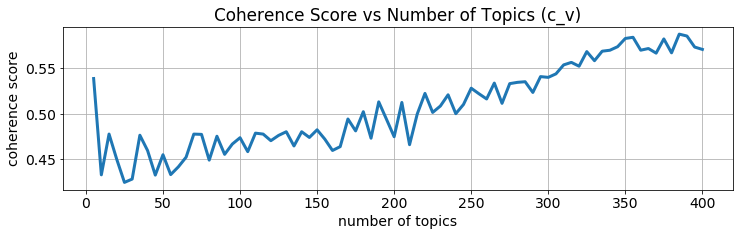

In [15]:
plot_coh(situation_lda_bow, 'c_v')

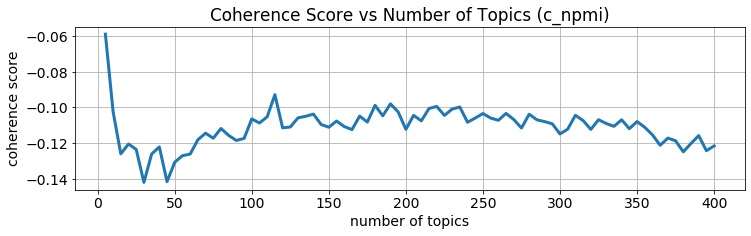

In [16]:
plot_coh(situation_lda_bow, 'c_npmi')

In [17]:
situation_lda_bow

,num_topic,model,c_v,c_npmi
0,5,"LdaModel(num_terms=1571, num_topics=5, decay=0...",0.538519,-0.058772
1,10,"LdaModel(num_terms=1571, num_topics=10, decay=...",0.432871,-0.102350
2,15,"LdaModel(num_terms=1571, num_topics=15, decay=...",0.477618,-0.126074
3,20,"LdaModel(num_terms=1571, num_topics=20, decay=...",0.449888,-0.120544
4,25,"LdaModel(num_terms=1571, num_topics=25, decay=...",0.424589,-0.123563
...,...,...,...,...
75,380,"LdaModel(num_terms=1571, num_topics=380, decay...",0.566704,-0.124944
76,385,"LdaModel(num_terms=1571, num_topics=385, decay...",0.587233,-0.120241
77,390,"LdaModel(num_terms=1571, num_topics=390, decay...",0.585153,-0.115823
78,395,"LdaModel(num_terms=1571, num_topics=395, decay...",0.573065,-0.124302


In [77]:
situ_lda_bow_best = situation_lda_bow[situation_lda_bow['num_topic'] == 350]['model'].tolist()[0]
print(situ_lda_bow_best)

LdaModel(num_terms=1571, num_topics=345, decay=0.5, chunksize=2000)


In [24]:
situ_lda_bow_best.save('../data/interim/situ_lda_bow_best')

In [85]:
situ_lda_bow_best2 = models.LdaModel(corpus = doc_term_bow, 
                              id2word = dictionary, 
                              num_topics = 350, 
                              passes = 20, 
                              random_state = 2020, 
                              alpha = 'auto')

In [78]:
def get_topic(model, doc):
    ppdoc = preprocess(doc)
    doc_term_arr = dictionary.doc2bow(ppdoc.split())
    try:
        res = sorted(model[doc_term_arr], 
                      key = lambda x: x[1], 
                      reverse = True)[0][0]
    except:
        print(doc)
        print(doc_term_arr)
        raise
    return res

In [79]:
# def get_topic2(model, doc, md_type):
#     ppdoc = preprocess(doc)
#     doc_term_arr = dictionary.doc2bow(ppdoc.split())
#     if md_type == 'tfidf':
#         doc_term_arr = tfidf_mod[doc_term_arr]
#     return sorted(model[doc_term_arr], 
#                   key = lambda x: x[1], 
#                   reverse = True)

In [80]:
def get_topic_clusters(model):
    df = situ_df.copy()
    df['topic_id'] = list(map(lambda x: get_topic(model, x), 
                              df['sop'].values.tolist()))
    return df

In [83]:
def func1(patn, lst):
    reg = re.findall(patn, ' '.join(lst), re.IGNORECASE)
    if reg:
        return True
    else:
        return False
    
def find_srs_pattern(patn, pd_srs):
    return list(map(lambda x: func1(patn, x), pd_srs))

situ_df[find_srs_pattern('domi', situ_df['sop'])]

,role,situation,sop,filename
3591,call taker,GPS tracked Panic Alarms,[See AB-DOMI],AB - ALARMD - Domestic violence alarm.docx


In [88]:
for t in nlp('See AB-DOMI'):
    print(t.text, t.pos_)

See VERB
AB PROPN
- PUNCT
DOMI PROPN


In [86]:
situ_lda_bow_topics = get_topic_clusters(situ_lda_bow_best2)

['See AB-DOMI']
[(1570, 1)]


IndexError: list index out of range

In [ ]:
situ_lda_tfidf_topics

In [21]:
raise Exception('Stop here')

Exception: Stop here

## Do not change anything below

In [ ]:
raise Exception('Stop here')

In [ ]:
calltaker_topic = calltaker_all.copy()
calltaker_topic['topic_id'] = list(map(lambda x: get_topic(lda_20, x), 
                                                        calltaker_topic['sop'].values.tolist()))
calltaker_topic[calltaker_topic['type'] == '1033']

In [ ]:
calltaker_topic = calltaker_topic.sort_values(by = ['topic_id', 'type', 'juri'], ignore_index = True)
calltaker_topic

In [ ]:
call_6 = calltaker_topic[calltaker_topic['topic_id'] == 6]
call_6

In [ ]:
calltaker_topic['topic_id'].unique()

In [ ]:
unwant = calltaker_topic[calltaker_topic['type'] == 'UNWANT']
unwant

In [ ]:
unwant['sop'].values.tolist()[-2:]

In [ ]:
call_6['sop'].values.tolist()[0]

In [ ]:
sents = call_6['sop'].tolist()[2]
sents[1:3]

In [ ]:
def get_entities(sent):
    ent1 = ''
    ent2 = ''
    prv_tok_dep = ''
    prv_tok_txt = ''
    prefix = ''
    mod = ''
    for tok in nlp(sent):
        if tok.dep_ != 'punct':
            if tok.dep_ == 'compound':
                prefix = tok.text
                if prv_tok_dep == 'compound':
                    prefix = prv_tok_text + ' ' + tok.text
            if tok.dep_.endswith('mod'):
                modifier = tok.text
                if prv_tok_dep == 'compound':
                    modifier = prv_tok_text + ' ' + tok.text
            if tok.dep_.find('sub'):
                ent1 = modifier + ' ' + prefix + ' ' + tok.text
                prefix = ''
                modifier = ''
                prv_tok_dep = ''
                prv_tok_text = ''
            if tok.dep_.find('obj'):
                ent2 = modifier + ' ' + prefix + ' ' + tok.text
            
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
        return ent1.strip(), ent2.strip()

In [ ]:
# df_call_withtopic = df_dispatcher.copy()
# df_call_withtopic.loc[:, 'topic_id'] = list(map(lambda x: get_topic(call_model_cv, x), 
#                                                 df_calltaker['sop'].values.tolist()))
# df_call_withtopic = df_call_withtopic.sort_values(by = ['topic_id', 'juri'], ignore_index = True)

In [ ]:
# df_call_withtopic

In [ ]:
# empty = pd.DataFrame()
# df1 = pd.DataFrame({'type': ['type1', 'type2'], 'value': [1, 2]})
# empty = empty.append(df1)
# empty = empty.append(df1)
# empty

#### Reflection of DRUGS coherence score
- the coherence score is very high for the one-topic model
- this makes sense, because we are looking at docs under the same type "DRUGS"

#### Question
- While the model assigns the documents with the correct topic, does this necessarily mean the documents are similar enough to be consolicated?
- LDA in not stable.  How will this instability affect us?

In [ ]:
type_list = sop_df['type'].values.tolist()
type_list[0]

In [ ]:
type_list = sop_df['type']
res = pd.DataFrame()
for event_type in type_list:
    dct = load_event(event_type)
    event_row = sop_df[sop_df['type'] == event_type]
    juri_to_filename = dict(zip(event_row['juri'].values[0], 
                            event_row['filename'].values[0]))
    juris, roles, sops, types = list(), list(), list(), list()
    for juri, role_sop in dct.items():
        for role, sop in role_sop.items():
            juris.append(juri)
            roles.append(role)
            sops.append(sop)
            types.append(event_type)
    typedf = pd.DataFrame({'type': types, 'juri': juris, 'role': roles, 'sop': sops})
    typedf['filename'] = typedf['juri'].apply(lambda x: juri_to_filename[x])
    df_calltaker = typedf[typedf['role'] == 'call taker']
    df_dispatcher = typedf[typedf['role'] == 'dispatcher']
    print(df_calltaker.shape)
    print(df_dispatcher.shape)

    for df in [df_calltaker, df_dispatcher]:
        if len(df) == 0:
            continue
        print('Start working on:', event_type, df['role'].unique())
        doc_term_matrix, corpus, dictionary = get_dct_dtmatrix(df['sop'])
        coherence_cv = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                            df['sop'].values.tolist())
        best_model_cv = coherence_cv.iloc[1:, :].sort_values('coherence_score')['model'].tolist()[-1]
        df_with_topic = df.copy()
        df_with_topic.loc[:, 'topic_id'] = list(map(lambda x: get_topic(best_model_cv, x), 
                                                        df['sop'].values.tolist()))
        df_with_topic = df_with_topic.sort_values(by = ['topic_id', 'juri'], ignore_index = True)
        res = res.append(df_with_topic)
        print('Finish working on:', event_type, df['role'].unique())

In [ ]:
ress = res.reset_index(drop = True)
ress

In [ ]:
from datetime import datetime 
dt = datetime.now().strftime('%Y-%m-%dT%H_%M_%S')
cwd = os.getcwd()
os.chdir(notebook_dir)
ress.to_csv(f'../data/interim/sop_topics_{dt}.csv', index = False)
os.chdir(cwd)

In [ ]:
print(type_list.values.tolist())

In [ ]:
ress[ (ress['type'] == 'MISCH') & (ress['role'] == 'call taker')]

In [ ]:
ress[ (ress['type'] == 'MISCH') & (ress['role'] == 'dispatcher')]

In [ ]:
ress[ (ress['type'] == 'ANIMAL') & (ress['role'] == 'call taker')]

In [ ]:
ress[ (ress['type'] == 'DRUGS') & (ress['role'] == 'call taker')]

In [ ]:
ress[ (ress['type'] == 'DRUGS') & (ress['role'] == 'call taker')]['sop'].values.tolist()[0]

In [ ]:
# all_coherence = topics_with_coherence(dt_matrix_all, corpus_all, dictionary_all, N = 20)

In [ ]:
# all_coherence

In [ ]:
# plt.figure(figsize = (12, 8))
# plt.plot(all_coherence.loc[:, 'num_topic'].values, all_coherence.loc[:, 'coherence_score'].values)
# plt.show()